## Imports

In [1]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from numba import njit, prange
from pyccel.epyccel import epyccel
from pyccel.decorators import types
import subprocess
import os
import shutil
import sys
import re
import pytest
import time

## Pure python function

In [2]:
def solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu):
    row, col = u.shape
    
    
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
    for n in range(nt + 1): 
        un = u.copy()
        u[1:-1, 1:-1] = (un[1:-1,1:-1] + 
                        nu * dt / dx**2 * 
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                        nu * dt / dy**2 * 
                        (un[2:,1: -1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))
        u[0, :] = 1
        u[-1, :] = 1
        u[:, 0] = 1
        u[:, -1] = 1

    
    
    
        
    return 0

## Numba accelerator

In [3]:
@njit(fastmath=True, parallel=True,)
def solve_2d_diff_numba(u, un, nt, dt, dx, dy, nu):
    row, col = u.shape
    
    ###Assign initial conditions
    # set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
    
    for n in prange(nt + 1): 
        un = u.copy()
        u[1:-1, 1:-1] = (un[1:-1,1:-1] + 
                        nu * dt / dx**2 * 
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                        nu * dt / dy**2 * 
                        (un[2:,1: -1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))
        u[0, :] = 1
        u[-1, :] = 1
        u[:, 0] = 1
        u[:, -1] = 1

    #fill the update of u
        
    return 0

## Pyccel accelerator

In [4]:
@types('float[:,:]', 'float[:,:]','int','float','float','float','float')
def solve_2d_diff_pyccel(u, un, nt, dt, dx, dy, nu):
  row, col = u.shape
    
  u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
 
  for j in range(0, nt + 1):
     un[:,:]=u[:,:]
     for ix in range(1, row):
        for iy in range(1, col):
            un[ix, iy] = u[ix, iy] + nu* (dt/ dx**2 )* (
                        u[ix + 1,iy] - 2 * u[ix,iy] + u[ix - 1,iy]) + (nu * dt / dy**2) * (
                                        u[ix,iy + 1] - 2 * u[ix,iy] + u[ix,iy - 1])

     u[0, :] = 1
     u[-1, :] = 1
     u[:, 0] = 1
     u[:, -1] = 1
    
    #fill the update of u and v
        
  return 0

## Inputs

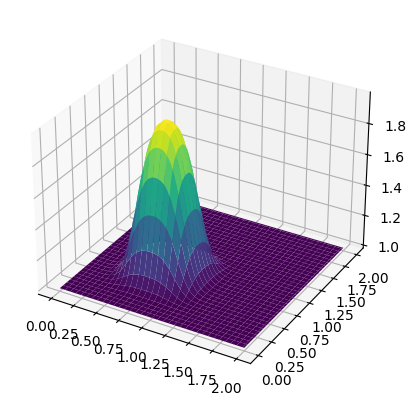

In [5]:
###variable declarations
nt = 51
nx = 101
ny = 101
nu = .05
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .25
dt = sigma * dx * dy / nu

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx))  # create a 1xn vector of 1's
un = np.ones((ny, nx))
    

solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)

## Call Funtions

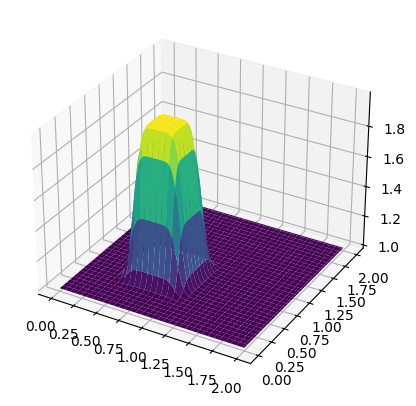

In [6]:
###variable declarations
nt = 14
nx = 101
ny = 101
nu = .05
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .25
dt = sigma * dx * dy / nu

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx))  # create a 1xn vector of 1's
un = np.ones((ny, nx))
    

solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)

### Pure function

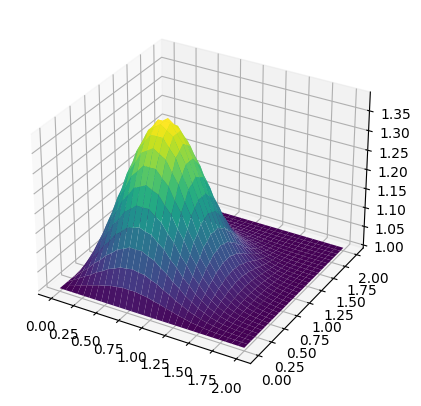

In [7]:
###variable declarations
nx = 31
ny = 31
nt = 50
nu = .05
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .25
dt = sigma * dx * dy / nu

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx))  # create a 1xn vector of 1's
un = np.ones((ny, nx))
    

solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)

In [8]:
%timeit solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu)

1.38 ms ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Function with numba accelerator

In [9]:
%timeit solve_2d_diff_numba(u, un, nt, dt, dx, dy, nu)

216 µs ± 51.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with pyccel accelerator

In [10]:
solve_2d_diff_f90 = epyccel(solve_2d_diff_pyccel)

In [11]:
%timeit solve_2d_diff_f90(u, un, nt, dt, dx, dy, nu)

93.9 µs ± 3.46 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
